# File setup from Github:

In [22]:
!pip install -q xlrd
!rm -f -r 150-DNN-Final
!git clone https://github.com/jeremyliweishih/150-DNN-Final

Cloning into '150-DNN-Final'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 97
Receiving objects: 100% (101/101), 826.69 KiB | 11.17 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [11]:
# Files from the cloned git repository.
!ls 150-DNN-Final/

BBB  BCNN-BBB.ipynb  README.md


In [0]:
#need to upload kaggle auth token
from google.colab import files
files.upload()

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  

100% 2.61G/2.62G [00:50<00:00, 27.6MB/s]
100% 2.62G/2.62G [00:51<00:00, 55.0MB/s]


In [24]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [47]:
!unzip HAM10000_images_part_1.zip
!unzip HAM10000_images_part_2.zip

Archive:  HAM10000_images_part_1.zip
  inflating: ISIC_0024306.jpg        
  inflating: ISIC_0024307.jpg        
  inflating: ISIC_0024308.jpg        
  inflating: ISIC_0024309.jpg        
  inflating: ISIC_0024310.jpg        
  inflating: ISIC_0024311.jpg        
  inflating: ISIC_0024312.jpg        
  inflating: ISIC_0024313.jpg        
  inflating: ISIC_0024314.jpg        
  inflating: ISIC_0024315.jpg        
  inflating: ISIC_0024316.jpg        
  inflating: ISIC_0024317.jpg        
  inflating: ISIC_0024318.jpg        
  inflating: ISIC_0024319.jpg        
  inflating: ISIC_0024320.jpg        
  inflating: ISIC_0024321.jpg        
  inflating: ISIC_0024322.jpg        
  inflating: ISIC_0024323.jpg        
  inflating: ISIC_0024324.jpg        
  inflating: ISIC_0024325.jpg        
  inflating: ISIC_0024326.jpg        
  inflating: ISIC_0024327.jpg        
  inflating: ISIC_0024328.jpg        
  inflating: ISIC_0024329.jpg        
  inflating: ISIC_0024330.jpg        
  inflating: 

In [48]:
!ls

150-DNN-Final		    ISIC_0027638.jpg  ISIC_0030981.jpg
2			    ISIC_0027639.jpg  ISIC_0030982.jpg
courses			    ISIC_0027640.jpg  ISIC_0030983.jpg
HAM10000_images_part_1.zip  ISIC_0027641.jpg  ISIC_0030984.jpg
HAM10000_images_part_2.zip  ISIC_0027642.jpg  ISIC_0030985.jpg
HAM10000_metadata.csv	    ISIC_0027643.jpg  ISIC_0030986.jpg
hmnist_28_28_L.csv	    ISIC_0027644.jpg  ISIC_0030987.jpg
hmnist_28_28_RGB.csv	    ISIC_0027645.jpg  ISIC_0030988.jpg
hmnist_8_8_L.csv	    ISIC_0027646.jpg  ISIC_0030989.jpg
hmnist_8_8_RGB.csv	    ISIC_0027647.jpg  ISIC_0030990.jpg
index.html		    ISIC_0027648.jpg  ISIC_0030991.jpg
ISIC_0024306.jpg	    ISIC_0027649.jpg  ISIC_0030992.jpg
ISIC_0024307.jpg	    ISIC_0027650.jpg  ISIC_0030993.jpg
ISIC_0024308.jpg	    ISIC_0027651.jpg  ISIC_0030994.jpg
ISIC_0024309.jpg	    ISIC_0027652.jpg  ISIC_0030995.jpg
ISIC_0024310.jpg	    ISIC_0027653.jpg  ISIC_0030996.jpg
ISIC_0024311.jpg	    ISIC_0027654.jpg  ISIC_0030997.jpg
ISIC_0024312.jpg	    ISIC_0027655.jpg  ISIC_0030

# Load images: 
loading code creds: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools


In [0]:
base_skin_dir = os.path.join('./', '')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [54]:
#load images and fillna
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [55]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


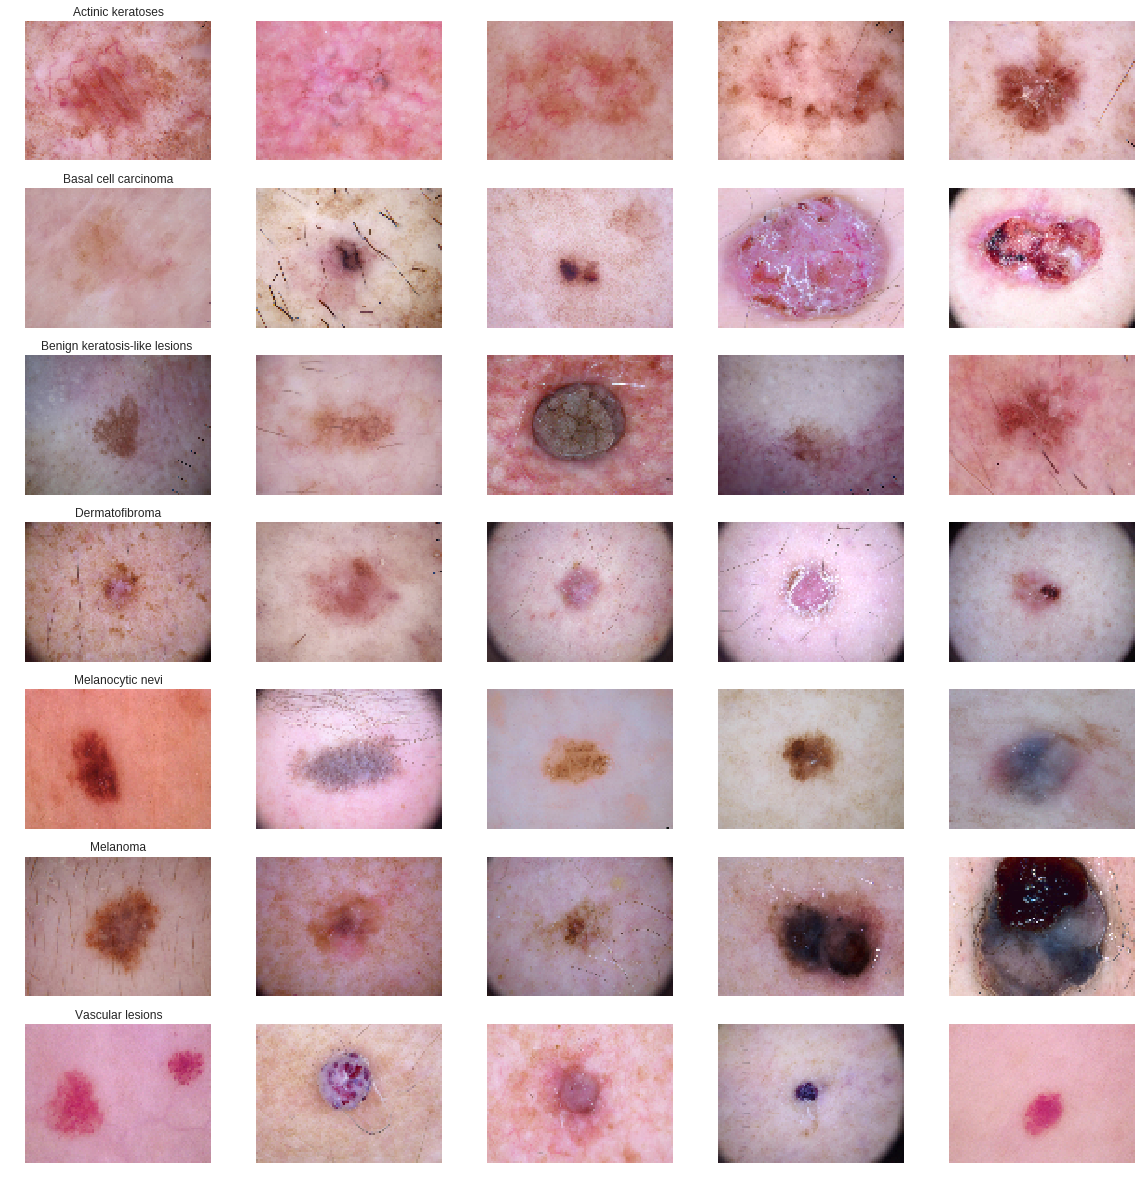

In [56]:
#check samples
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)